Import Libraries and Data

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Load Dataset
# Making train and validation set
dataset_name = 'tf_flowers'
(dataset_train, dataset_val), dataset_info = tfds.load(
    dataset_name, split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)

# Get class names and count
class_names = dataset_info.features['label'].names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.DXV5SZ_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Number of classes: 5


Class Distribution and Weights

In [2]:
class_counts = np.zeros(num_classes, dtype=np.int32)
for _, label in tfds.as_numpy(dataset_train):
    class_counts[label] += 1

print("\nClass distribution in training set:")
for i, count in enumerate(class_counts):
    print(f"Class '{class_names[i]}': {count} samples")

# Calculate class weights
if np.any(class_counts == 0):
    print("\nWarning: Some classes have zero samples in the training set. Class weights may not be meaningful.")
    class_weights = {i: 1.0 for i in range(num_classes)}
else:
    class_weights_calc = {i: 1.0 / count for i, count in enumerate(class_counts)}
    total_weight_sum = sum(class_weights_calc.values())
    class_weights = {i: (weight / total_weight_sum) * num_classes for i, weight in class_weights_calc.items()}
print("\nCalculated class weights:", class_weights)

# Check label type (integer or one-hot)
for image, label in dataset_train.take(1):
    print("\nExample label:", label.numpy())
    # Output is integer, so labels are integer-encoded. We use sparse_categorical_crossentropy.


Class distribution in training set:
Class 'dandelion': 739 samples
Class 'daisy': 513 samples
Class 'tulips': 613 samples
Class 'sunflowers': 561 samples
Class 'roses': 510 samples

Calculated class weights: {0: np.float64(0.7797389558107419), 1: np.float64(1.1232496848813611), 2: np.float64(0.9400115633672729), 3: np.float64(1.027142759971726), 4: np.float64(1.1298570359688984)}

Example label: 2


Preprocessing

In [3]:
img_height = 224
img_width = 224
batch_size = 32

# MobileNetV2 specific preprocessing function
def mobilenet_v2_preprocess(image, label):
    image = tf.image.resize(image, (img_height, img_width))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image) # Scales pixels to [-1, 1]
    return image, label

train_data = dataset_train.map(mobilenet_v2_preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = dataset_val.map(mobilenet_v2_preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)


Data Augmentation

In [4]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name="data_augmentation")

Model Building

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base model for initial training

# Build the full model
model = Sequential([
    Input(shape=(img_height, img_width, 3), name="input_layer"),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(name="global_avg_pool"),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0005), name="dense_1"),
    Dropout(0.5, name="dropout_1"),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005), name="dense_2"),
    Dropout(0.3, name="dropout_2"),
    Dense(num_classes, activation='softmax', name="output_layer")
], name="MobileNetV2_TransferLearning")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Compile Model

In [6]:
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "MobileNetV2_TransferLearning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,461 (9.99 MB)

 Trainable params: 361,477 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Callbacks

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

Train Model

In [8]:
epochs = 25

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    class_weight=class_weights, # Use class weights if dataset is imbalanced
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.3132 - loss: 1.9429 - val_accuracy: 0.6935 - val_loss: 1.2389 - learning_rate: 1.0000e-04
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.6013 - loss: 1.3137 - val_accuracy: 0.7929 - val_loss: 0.9335 - learning_rate: 1.0000e-04
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.7034 - loss: 1.0666 - val_accuracy: 0.8351 - val_loss: 0.8037 - learning_rate: 1.0000e-04
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.7550 - loss: 0.9561 - val_accuracy: 0.8488 - val_loss: 0.7394 - learning_rate: 1.0000e-04
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.7832 - loss: 0.8890 - val_accuracy: 0.8733 - val_loss: 0.6810 - learning_rate: 1.0000e-04
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7930 - loss: 0.8444 - val_accuracy: 0.8678 - val_loss: 0.6562 - learning_rate: 1.0000e-04
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8

Plotting Training History

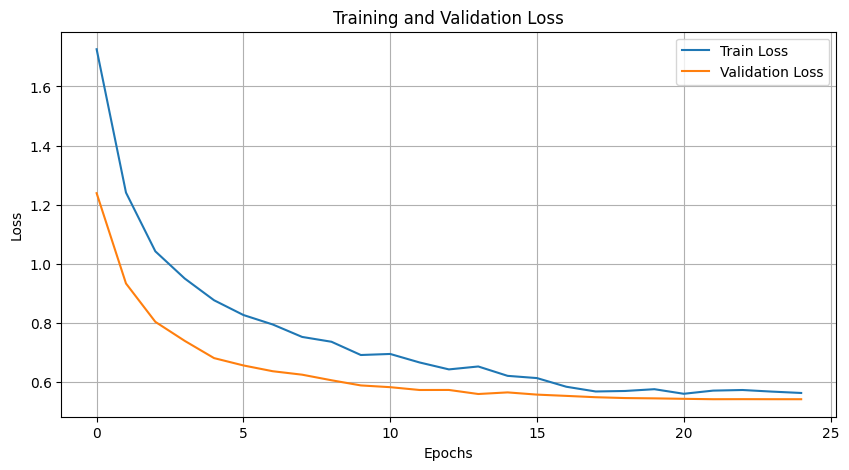

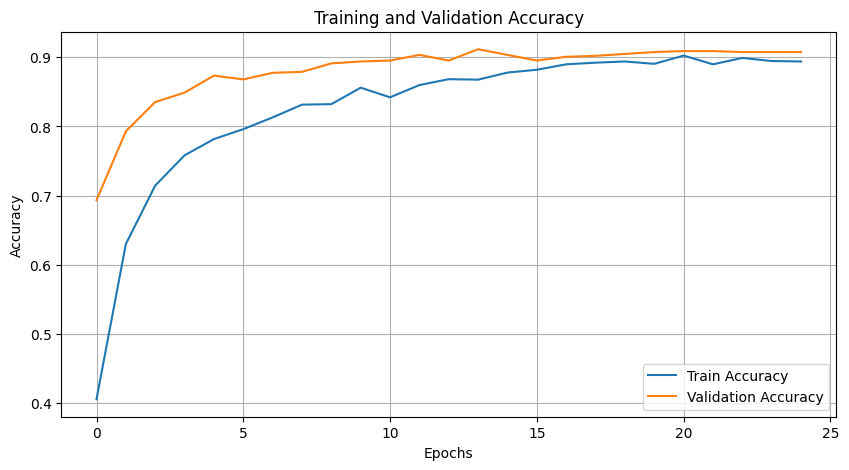

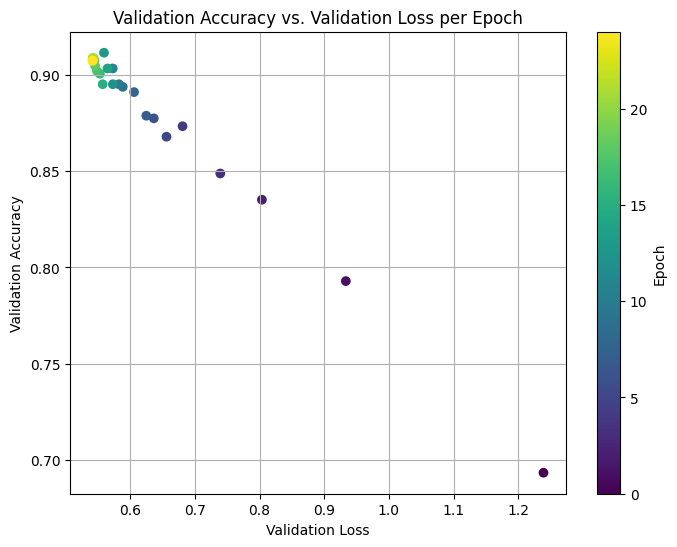

In [9]:
# Plot Training loss vs Validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Accuracy vs Validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy vs Validation Loss (scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(history.history['val_loss'], history.history['val_accuracy'], c=np.arange(len(history.history['val_loss'])), cmap='viridis')
plt.colorbar(label='Epoch')
plt.xlabel('Validation Loss')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Validation Loss per Epoch')
plt.grid(True)
plt.show()

Evaluate Model

In [10]:
print("\nEvaluating on Training Data:")
train_loss, train_accuracy = model.evaluate(train_data)
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

print("\nEvaluating on Validation Data:")
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')


Evaluating on Training Data:
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9279 - loss: 0.4954
Train Loss: 0.4937
Train Accuracy: 92.40%

Evaluating on Validation Data:
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9149 - loss: 0.5455
Validation Loss: 0.5420
Validation Accuracy: 90.74%


Confusion Matrix and Classification Report

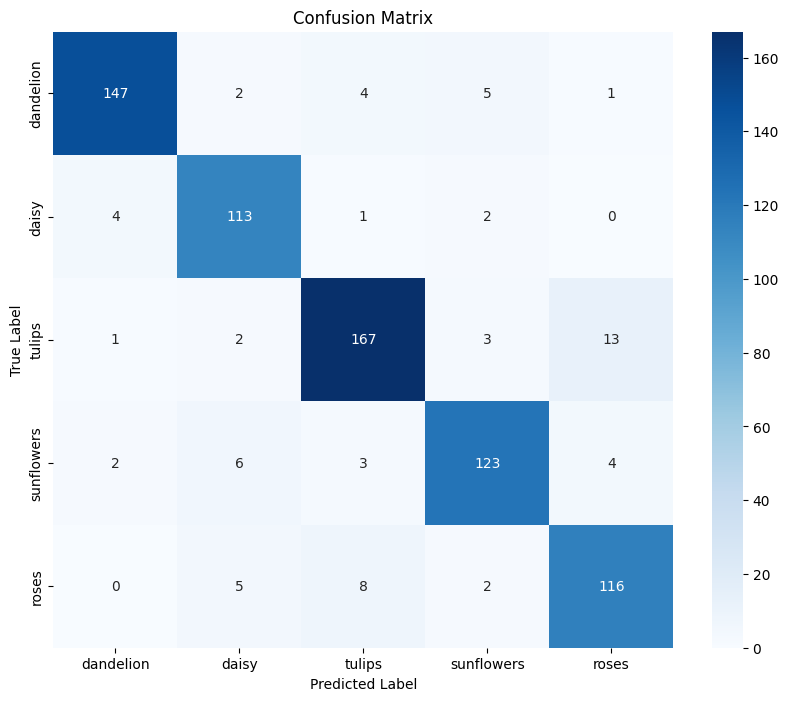


Classification Report:
               precision    recall  f1-score   support

   dandelion       0.95      0.92      0.94       159
       daisy       0.88      0.94      0.91       120
      tulips       0.91      0.90      0.91       186
  sunflowers       0.91      0.89      0.90       138
       roses       0.87      0.89      0.88       131

    accuracy                           0.91       734
   macro avg       0.91      0.91      0.91       734
weighted avg       0.91      0.91      0.91       734



In [11]:
y_true = []
y_pred_probs = []

for images, labels in val_data: # Iterate through the validation dataset
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(predictions)

y_pred = np.argmax(y_pred_probs, axis=1) # Convert probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names, zero_division=0))



Visualize Predictions

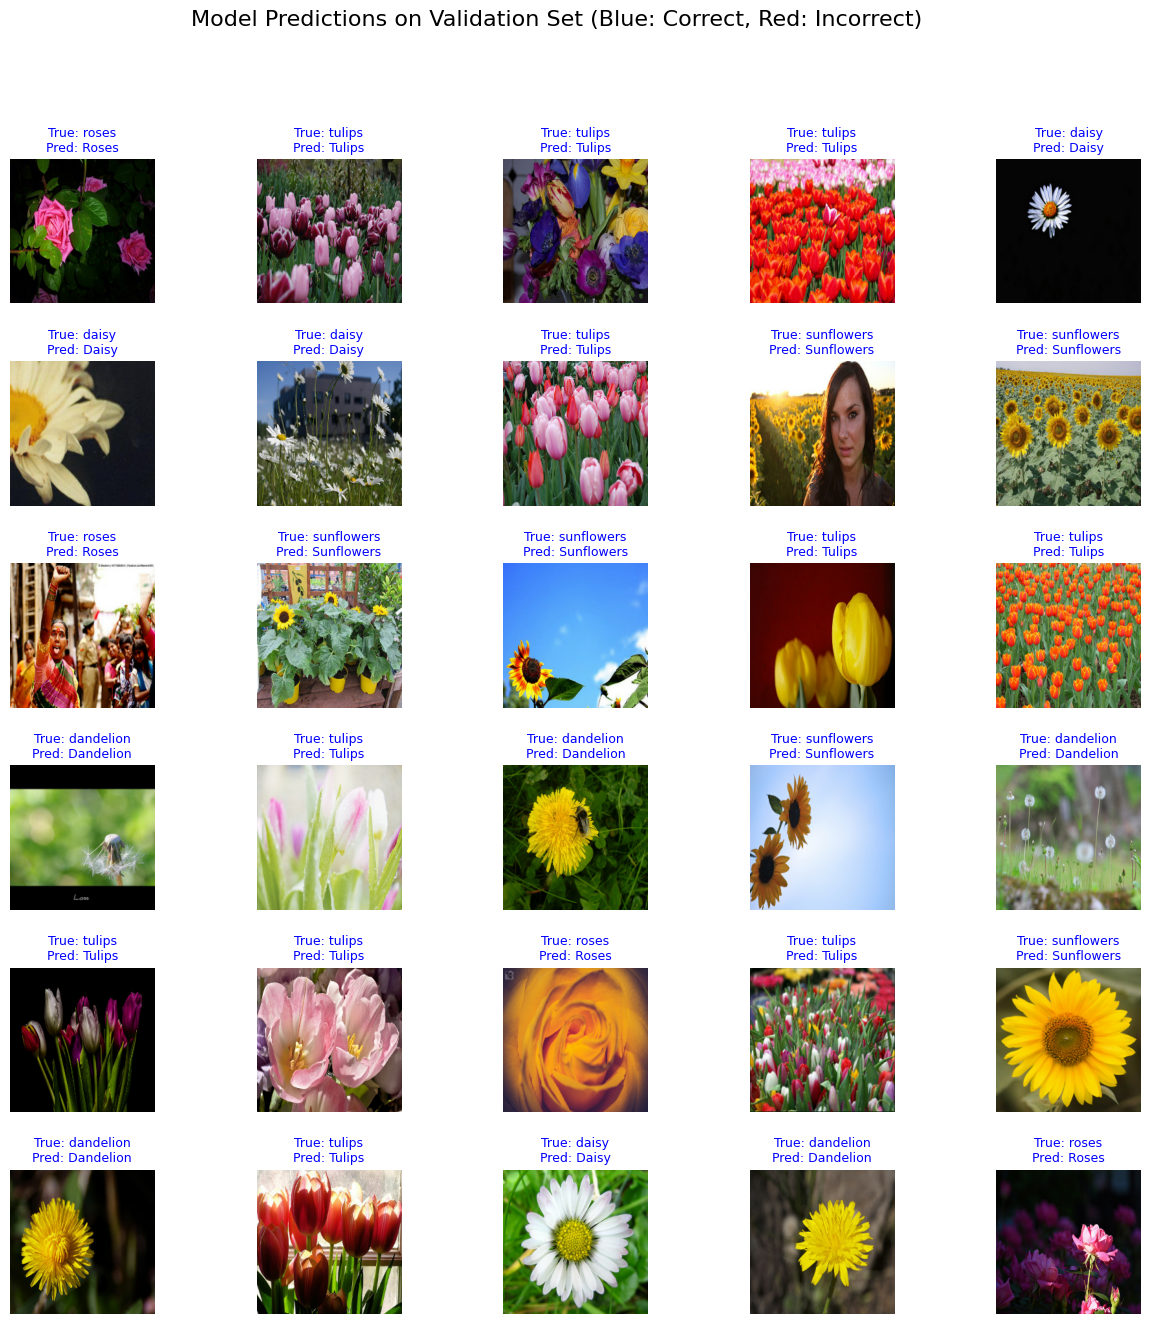

In [12]:
# Function to denormalize images for display if needed
# MobileNetV2 preprocess_input scales to [-1, 1]
def denormalize_image(image):
    image = (image + 1.0) / 2.0 # Rescale from [-1, 1] to [0, 1]
    return np.clip(image, 0, 1)

# Get a batch of images and labels from the validation set for visualization
image_batch_val, label_batch_val = next(iter(val_data))
# We need the original images if we want to display them without preprocessing artifacts.
# For simplicity, we'll display the preprocessed ones, but note they are normalized.
# Or, it's better to take from dataset_val *before* preprocessing for visualization.

# Get original images for display (optional, but better for visualization)
original_image_batch_val, original_label_batch_val = next(iter(dataset_val.map(lambda image, label: (tf.image.resize(image, (img_height, img_width)), label)).batch(batch_size)))


predicted_batch_probs = model.predict(image_batch_val, verbose=0) # image_batch_val is already preprocessed
predicted_ids = np.argmax(predicted_batch_probs, axis=-1)
predicted_class_names = np.array(class_names)[predicted_ids]
true_class_names = np.array(class_names)[original_label_batch_val.numpy()]


plt.figure(figsize=(15, 15))
for n in range(min(30, batch_size)): # Display up to 30 images or batch size
    plt.subplot(6, 5, n + 1)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # Display original image
    img_display = original_image_batch_val[n].numpy().astype("uint8") # Assuming original images are uint8
    plt.imshow(img_display)

    color = "blue" if predicted_ids[n] == original_label_batch_val[n].numpy() else "red"
    title_str = f"True: {true_class_names[n]}\nPred: {predicted_class_names[n].title()}"
    plt.title(title_str, color=color, fontsize=9)
    plt.axis('off')
plt.suptitle("Model Predictions on Validation Set (Blue: Correct, Red: Incorrect)", fontsize=16)
plt.show()

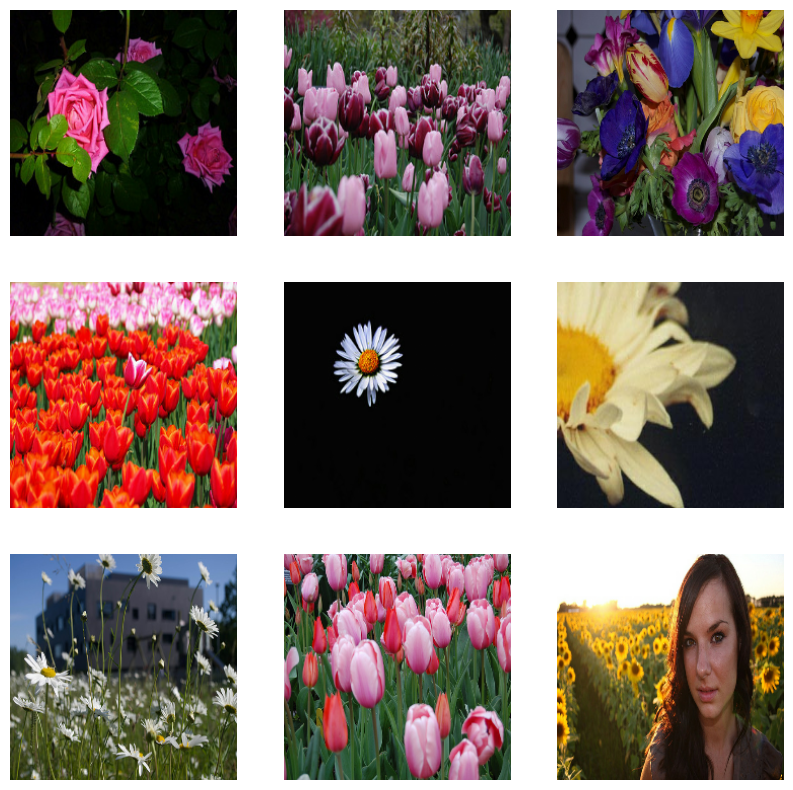

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Get a batch of preprocessed images from val_data
image_batch_val, _ = next(iter(val_data))

# Function to denormalize images for display
def denormalize_image(image):
    image = (image + 1.0) / 2.0  # Rescale from [-1, 1] to [0, 1]
    return np.clip(image, 0, 1)

# Display a few preprocessed images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # Denormalize the image before displaying
    image = denormalize_image(image_batch_val[i].numpy())
    plt.imshow(image)
    plt.axis('off')

plt.show()